# Machine Learning Portfolio
Antoine ROZE-NIEF
H00384166

I chose the Intel Classification Dataset because I wanted to try an image recognition system.
https://www.kaggle.com/puneet6060/intel-image-classification
This dataset interested me because it had 6 categories and complex images.

In [3]:
import sys
assert sys.version_info >= (3, 5)

Importing Scikit-Learn and making sure it is a good version

In [4]:
import sklearn
assert sklearn.__version__ >= "0.20" 

Importing the differents libraries needed.
OpenCV and PIL for image treatment, Matplotlib to show the images and make some graphs and the different functions for sklearn to make predictions and getting the confusion matrixes.

In [5]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import fnmatch
import cv2 as cv
from PIL import Image
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import multilabel_confusion_matrix
from sklearn.decomposition import PCA

I also installed another package called mlxtend to create my confusion matrixes, using the anaconda terminal and the command:

conda install -c conda-forge mlxtend

In [6]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [7]:
#Creating the different folders for training, testing and predicting
mainFolderTrain = 'Intel Image Classification/seg_train'
mainFolderTest = 'Intel Image Classification/seg_test'
mainFolderPred = 'Intel Image Classification/seg_pred'
directoryTrain = os.listdir(mainFolderTrain)
directoryTest = os.listdir(mainFolderTest)
directoryPred = os.listdir(mainFolderPred)

Firstly, I showed 4 consecutives images for each category randomly

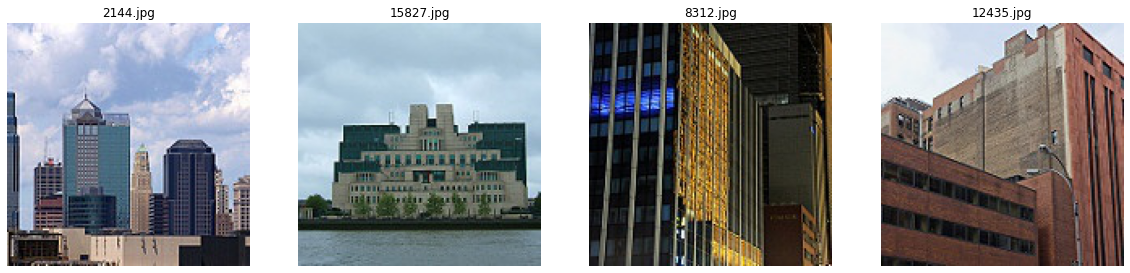

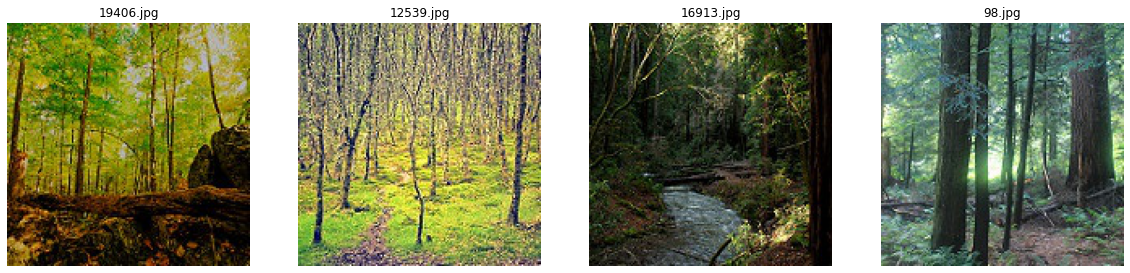

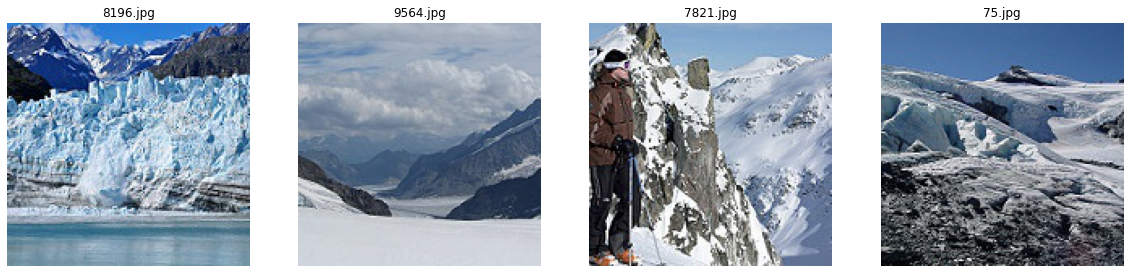

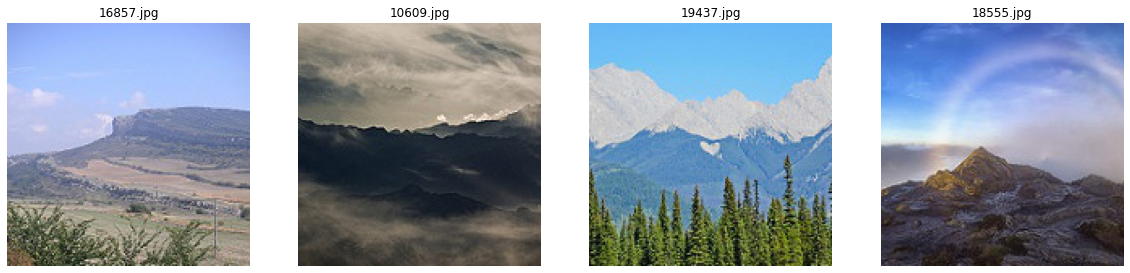

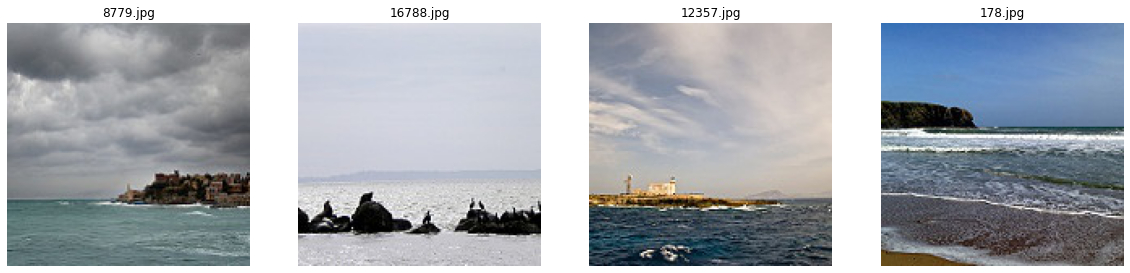

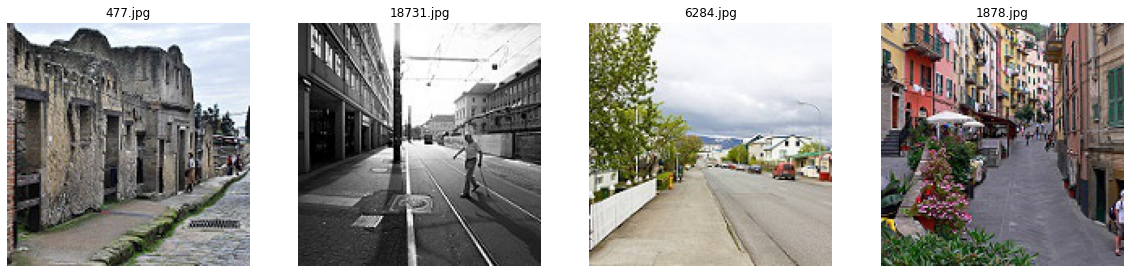

In [8]:
for each in directoryTrain:
    plt.figure(figsize=(20,20))
    subFolder = mainFolderTrain + '/' + each
    for i in range(4):
        file = random.choice(os.listdir(subFolder))#Choose a random file (image) from the subfolder
        imagePath= os.path.join(subFolder, file)
        img=mpimg.imread(imagePath)
        ax=plt.subplot(1,4,i+1)#Puts the random image on a 1*4 grid
        ax.title.set_text(file)#Gets the title of the file on top of the image
        plt.axis('off')
        plt.imshow(img)#Show the image

Each row correspond to a different category

Then I used OpenCV to get the resolution as well as a test to see if a random image is in color or greyscaled

In [9]:
randomFolder = random.choice(os.listdir('Intel Image Classification/seg_train'))#Getting a random category from the 6 available
randomImage = random.choice(os.listdir('Intel Image Classification/seg_train' + '/' + randomFolder))#Getting a random file from the category choosed earlier
randomImgPath = 'Intel Image Classification/seg_train' + '/' + randomFolder + '/' + randomImage

img = cv.imread(randomImgPath)
resX = img.shape[0]#Height of the image
resY = img.shape[1]#Width of the image
print('Image resolution of' , randomImgPath , 'is' , resX , 'x' , resY , 'pixels')
imgDim = img.shape#Other way of getting the dimension of the image, with the added data of the number of channels
print(imgDim)
if imgDim[2] == 3:
    print('The image is in color')
else:
    print('The image is greyscaled')

Image resolution of Intel Image Classification/seg_train/mountain/5035.jpg is 150 x 150 pixels
(150, 150, 3)
The image is in color


buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images


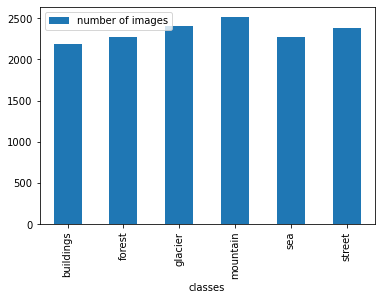

In [10]:
categories = []
nbFiles = []
for each in directoryTrain:
    subFolder = mainFolderTrain + '/' + each
    categories.append(os.path.basename(subFolder))
    nbFiles.append(len(fnmatch.filter(os.listdir(subFolder), '*.jpg')))
    print(str(categories[-1]) + ': ' + str(nbFiles[-1]) + ' images')
    
df = pd.DataFrame({'classes':categories, 'number of images':nbFiles})
ax = df.plot.bar(x='classes', y='number of images')

I chose to convert the image from color to greyscale to simplify the data that need to be processed later.
Also, I used the cv2.resize function to get all the images to the same resolution.


[[124 113 107 ... 123 102  90]
 [ 88 123 115 ... 107 136 120]
 [ 89 124 143 ...  88 129  55]
 ...
 [ 35  87 174 ... 100 132  73]
 [ 54 168 182 ... 136 163  92]
 [ 89 115 162 ... 128 122  94]]
(150, 150)


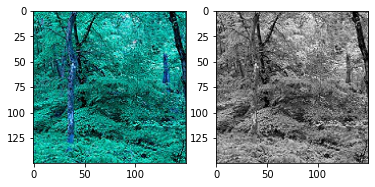

In [11]:
randomFolder = random.choice(os.listdir('Intel Image Classification/seg_train'))#Getting a random category from the 6 available
randomImage = random.choice(os.listdir('Intel Image Classification/seg_train' + '/' + randomFolder))#Getting a random file from the category choosed earlier
randomImgPath = 'Intel Image Classification/seg_train' + '/' + randomFolder + '/' + randomImage

# img=mpimg.imread(imagePath)
# plt.imshow(mpimg.imread(randomImgPath, cv.COLOR_BGR2GRAY))

img = cv.imread(randomImgPath)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# img2 = img[:,:,::-1]
ax=plt.subplot(1,2,1)#Puts the random image on a 1*4 grid
plt.imshow(img)
ax=plt.subplot(1,2,2)#Puts the random image on a 1*4 grid
plt.imshow(gray, cmap = plt.cm.gray)

print(np.array(gray))
print(gray.shape)

# for i in range(4):
#     file = random.choice(os.listdir(subFolder))#Choose a random file (image) from the subfolder
#     imagePath= os.path.join(subFolder, file)
#     img=mpimg.imread(imagePath)
#     ax=plt.subplot(1,4,i+1)#Puts the random image on a 1*4 grid
#     ax.title.set_text(file)#Gets the title of the file on top of the image
#     plt.axis('off')
#     plt.imshow(img)#Show the image

In [12]:
print(nbFiles)

[2191, 2271, 2404, 2512, 2274, 2382]


Then I chose to greatly downscale the images to have less attributes, and also to get faster running times, and lighter datasets that are easier to manipulate.

In [13]:
fixedResX=30
fixedResY=30

Finally, I created the dataframes for the training set and the testing set.

In [14]:

data_train=[]
classes_train=[]


for each in directoryTrain:
    for file in os.listdir(os.path.join(mainFolderTrain, each)):
       
        image_path = os.path.join(mainFolderTrain, each,  file)
        image = cv.imread( image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)#Converting a color (BGR) image to grayscale
        image = cv.resize(image, (fixedResX, fixedResY),interpolation = cv.INTER_AREA)#Resizing the image to the fixed resolution chosen earlier
        image = image.flatten()
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 #Normalizing the pixel values
        data_train.append(image)
        classes_train.append(each)
        

In [15]:
data_test=[]
classes_test=[]
for each in directoryTest:
    for file in os.listdir(os.path.join(mainFolderTest, each)):
       
        image_path = os.path.join(mainFolderTest, each,  file)
        image = cv.imread( image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)#Converting a color (BGR) image to grayscale
        image = cv.resize(image, (fixedResX, fixedResY),interpolation = cv.INTER_AREA)#Resizing the image to the fixed resolution chosen earlier
        image = image.flatten()
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 #Normalizing the pixel values
        data_test.append(image)
        classes_test.append(each)

In [16]:
#Creating the different dataframes for training and testing
df_train = pd.DataFrame(data=[data_train,classes_train]).T
df_train = df_train.reset_index()
df_train.columns = ['Index','Pixels values','Classes']
del df_train['Index']

df_test = pd.DataFrame(data=[data_test,classes_test]).T
df_test = df_test.reset_index()
df_test.columns = ['Index','Pixels values','Classes']
del df_test['Index']

Once the datasets are created, they have only 2 columns, one with a full array for the image, and the other for the class of the image, so I had to separate each pixel in a column to make it easier for the programming down the line.

In [17]:
df_train.head(10)

Pixels values    Classes
0  [0.96862745, 0.9764706, 0.9764706, 0.972549, 0...  buildings
1  [0.4509804, 0.44705883, 0.4392157, 0.43529412,...  buildings
2  [0.7058824, 0.7058824, 0.67058825, 0.62352943,...  buildings
3  [0.6901961, 0.6666667, 0.6784314, 0.46666667, ...  buildings
4  [0.10980392, 0.105882354, 0.10980392, 0.117647...  buildings
5  [0.9098039, 0.92941177, 0.92156863, 0.91764706...  buildings
6  [0.5058824, 0.5137255, 0.5176471, 0.5254902, 0...  buildings
7  [0.7137255, 0.7137255, 0.7176471, 0.7176471, 0...  buildings
8  [0.972549, 0.96862745, 0.972549, 0.972549, 0.9...  buildings
9  [0.7372549, 0.7372549, 0.7411765, 0.7411765, 0...  buildings

In [18]:
df_train = pd.DataFrame(df_train['Pixels values'].tolist())

In [19]:
df_train.head(10)

0         1         2         3         4         5         6    \
0  0.968627  0.976471  0.976471  0.972549  0.976471  0.980392  0.976471   
1  0.450980  0.447059  0.439216  0.435294  0.435294  0.443137  0.450980   
2  0.705882  0.705882  0.670588  0.623529  0.615686  0.603922  0.623529   
3  0.690196  0.666667  0.678431  0.466667  0.474510  0.721569  0.752941   
4  0.109804  0.105882  0.109804  0.117647  0.133333  0.156863  0.160784   
5  0.909804  0.929412  0.921569  0.917647  0.886275  0.862745  0.858824   
6  0.505882  0.513726  0.517647  0.525490  0.533333  0.552941  0.568627   
7  0.713726  0.713726  0.717647  0.717647  0.709804  0.709804  0.705882   
8  0.972549  0.968627  0.972549  0.972549  0.976471  0.980392  0.980392   
9  0.737255  0.737255  0.741176  0.741176  0.741176  0.741176  0.741176   

        7         8         9    ...       890       891       892       893  \
0  0.976471  0.976471  0.976471  ...  0.211765  0.133333  0.176471  0.200000   
1  0.462745  0.494118  0.533333  ...  0.137255  0.125490  0.082353  0.149020   
2  0.717647  0.713726  0.717647  ...  0.541176  0.525490  0.533333  0.529412   
3  0.772549  0.780392  0.792157  ...  0.717647  0.827451  0.780392  0.474510   
4  0.188235  0.200000  0.200000  ...  0.560784  0.521569  0.686275  0.831373   
5  0.854902  0.850980  0.847059  ...  0.039216  0.090196  0.086275  0.129412   
6  0.576471  0.600000  0.619608  ...  0.600000  0.600000  0.600000  0.580392   
7  0.705882  0.733333  0.737255  ...  0.301961  0.309804  0.301961  0.298039   
8  0.984314  0.988235  0.992157  ...  0.384314  0.411765  0.439216  0.439216   
9  0.741176  0.741176  0.741176  ...  0.466667  0.533333  0.439216  0.541176   

        894       895       896       897       898       899  
0  0.145098  0.152941  0.160784  0.243137  0.207843  0.207843  
1  0.070588  0.074510  0.133333  0.149020  0.133333  0.219608  
2  0.521569  0.525490  0.521569  0.529412  0.525490  0.533333  
3  0.701961  0.847059  0.494118  0.384314  0.796078  0.905882  
4  0.494118  0.835294  0.627451  0.705882  0.396078  0.843137  
5  0.117647  0.050980  0.062745  0.058824  0.070588  0.047059  
6  0.564706  0.584314  0.603922  0.603922  0.592157  0.580392  
7  0.298039  0.301961  0.305882  0.301961  0.305882  0.305882  
8  0.411765  0.388235  0.380392  0.376471  0.380392  0.364706  
9  0.494118  0.498039  0.494118  0.482353  0.478431  0.466667  

[10 rows x 900 columns]

In [20]:
df_test = pd.DataFrame(df_test['Pixels values'].tolist())

In [21]:
df_train['Classes Train'] = classes_train
print("Here, each pixel is assigned to a column, and each line is a full image")
df_train.head(10)

Here, each pixel is assigned to a column, and each line is a full image


0         1         2         3         4         5         6  \
0  0.968627  0.976471  0.976471  0.972549  0.976471  0.980392  0.976471   
1  0.450980  0.447059  0.439216  0.435294  0.435294  0.443137  0.450980   
2  0.705882  0.705882  0.670588  0.623529  0.615686  0.603922  0.623529   
3  0.690196  0.666667  0.678431  0.466667  0.474510  0.721569  0.752941   
4  0.109804  0.105882  0.109804  0.117647  0.133333  0.156863  0.160784   
5  0.909804  0.929412  0.921569  0.917647  0.886275  0.862745  0.858824   
6  0.505882  0.513726  0.517647  0.525490  0.533333  0.552941  0.568627   
7  0.713726  0.713726  0.717647  0.717647  0.709804  0.709804  0.705882   
8  0.972549  0.968627  0.972549  0.972549  0.976471  0.980392  0.980392   
9  0.737255  0.737255  0.741176  0.741176  0.741176  0.741176  0.741176   

          7         8         9  ...       891       892       893       894  \
0  0.976471  0.976471  0.976471  ...  0.133333  0.176471  0.200000  0.145098   
1  0.462745  0.494118  0.533333  ...  0.125490  0.082353  0.149020  0.070588   
2  0.717647  0.713726  0.717647  ...  0.525490  0.533333  0.529412  0.521569   
3  0.772549  0.780392  0.792157  ...  0.827451  0.780392  0.474510  0.701961   
4  0.188235  0.200000  0.200000  ...  0.521569  0.686275  0.831373  0.494118   
5  0.854902  0.850980  0.847059  ...  0.090196  0.086275  0.129412  0.117647   
6  0.576471  0.600000  0.619608  ...  0.600000  0.600000  0.580392  0.564706   
7  0.705882  0.733333  0.737255  ...  0.309804  0.301961  0.298039  0.298039   
8  0.984314  0.988235  0.992157  ...  0.411765  0.439216  0.439216  0.411765   
9  0.741176  0.741176  0.741176  ...  0.533333  0.439216  0.541176  0.494118   

        895       896       897       898       899  Classes Train  
0  0.152941  0.160784  0.243137  0.207843  0.207843      buildings  
1  0.074510  0.133333  0.149020  0.133333  0.219608      buildings  
2  0.525490  0.521569  0.529412  0.525490  0.533333      buildings  
3  0.847059  0.494118  0.384314  0.796078  0.905882      buildings  
4  0.835294  0.627451  0.705882  0.396078  0.843137      buildings  
5  0.050980  0.062745  0.058824  0.070588  0.047059      buildings  
6  0.584314  0.603922  0.603922  0.592157  0.580392      buildings  
7  0.301961  0.305882  0.301961  0.305882  0.305882      buildings  
8  0.388235  0.380392  0.376471  0.380392  0.364706      buildings  
9  0.498039  0.494118  0.482353  0.478431  0.466667      buildings  

[10 rows x 901 columns]

In [22]:
df_test['Classes Test'] = classes_test
df_test.head(10)

0         1         2         3         4         5         6  \
0  0.654902  0.921569  0.886275  0.803922  0.921569  0.925490  0.925490   
1  0.650980  0.650980  0.650980  0.650980  0.654902  0.643137  0.654902   
2  0.882353  0.898039  0.905882  0.933333  0.952941  0.956863  0.945098   
3  0.670588  0.678431  0.678431  0.701961  0.713726  0.705882  0.705882   
4  0.301961  0.298039  0.301961  0.301961  0.301961  0.301961  0.305882   
5  0.725490  0.701961  0.662745  0.643137  0.643137  0.631373  0.607843   
6  0.588235  0.588235  0.588235  0.592157  0.592157  0.592157  0.596078   
7  0.992157  0.996078  1.000000  1.000000  1.000000  1.000000  1.000000   
8  0.533333  0.533333  0.533333  0.537255  0.537255  0.541176  0.549020   
9  0.321569  0.407843  0.423529  0.431373  0.435294  0.447059  0.466667   

          7         8         9  ...       891       892       893       894  \
0  0.901961  0.898039  0.909804  ...  0.321569  0.352941  0.317647  0.278431   
1  0.654902  0.654902  0.654902  ...  0.588235  0.580392  0.568627  0.580392   
2  0.937255  0.917647  0.925490  ...  0.309804  0.301961  0.352941  0.380392   
3  0.709804  0.713726  0.717647  ...  0.152941  0.141176  0.156863  0.113725   
4  0.305882  0.305882  0.305882  ...  0.721569  0.450980  0.058824  0.070588   
5  0.592157  0.576471  0.576471  ...  0.423529  0.400000  0.439216  0.396078   
6  0.596078  0.596078  0.596078  ...  0.690196  0.552941  0.345098  0.254902   
7  1.000000  1.000000  1.000000  ...  0.580392  0.588235  0.592157  0.584314   
8  0.552941  0.560784  0.568627  ...  0.243137  0.462745  0.505882  0.411765   
9  0.474510  0.478431  0.470588  ...  0.337255  0.356863  0.380392  0.396078   

        895       896       897       898       899  Classes Test  
0  0.192157  0.188235  0.250980  0.768627  0.901961     buildings  
1  0.572549  0.568627  0.568627  0.560784  0.556863     buildings  
2  0.250980  0.062745  0.133333  0.109804  0.125490     buildings  
3  0.152941  0.192157  0.207843  0.184314  0.250980     buildings  
4  0.078431  0.078431  0.078431  0.070588  0.058824     buildings  
5  0.427451  0.372549  0.388235  0.407843  0.376471     buildings  
6  0.243137  0.200000  0.239216  0.176471  0.207843     buildings  
7  0.588235  0.552941  0.556863  0.552941  0.521569     buildings  
8  0.517647  0.517647  0.482353  0.498039  0.501961     buildings  
9  0.403922  0.411765  0.407843  0.411765  0.411765     buildings  

[10 rows x 901 columns]

In [23]:
df_train.to_csv('Training Dataset.csv')
df_test.to_csv('Testing Dataset.csv')

In [24]:
pixelNumb=fixedResX*fixedResY
print(pixelNumb)

900


Saving the dataset to csv if needed in future for easier access

In [25]:
X_train=df_train.iloc[: , :(pixelNumb-1)]
X_test=df_test.iloc[: , :(pixelNumb-1)]
y_train=df_train['Classes Train']
y_test=df_test['Classes Test']

In [26]:
target_dict_train={k: v for v, k in enumerate(np.unique(y_train))}
target_dict_test={k: v for v, k in enumerate(np.unique(y_test))}

In [27]:
target_val_train =  [target_dict_train[y_train[i]] for i in range(len(y_train))]
target_val_test =  [target_dict_test[y_train[i]] for i in range(len(y_test))]

In [28]:
df_train['Class Number'] = target_val_train
df_test['Class Number'] = target_val_test

In [29]:
df_train_random = df_train.sample(frac = 1)
df_test_random = df_test.sample(frac = 1)
  
# print the shuffled DataFrame
print("\nShuffled DataFrame:")
df_train_random.head(10)


Shuffled DataFrame:


0         1         2         3         4         5         6  \
3141   0.694118  0.694118  0.552941  0.462745  0.482353  0.419608  0.713726   
11329  0.415686  0.415686  0.407843  0.392157  0.396078  0.392157  0.403922   
3334   0.478431  0.788235  0.662745  0.305882  0.403922  0.301961  0.239216   
12563  0.176471  0.180392  0.505882  0.560784  0.733333  0.364706  0.337255   
3787   0.294118  0.305882  0.262745  0.313726  0.227451  0.450980  0.250980   
8892   0.533333  0.827451  0.831373  0.839216  0.831373  0.835294  0.827451   
4897   0.592157  0.603922  0.611765  0.619608  0.627451  0.635294  0.643137   
688    0.972549  0.968627  0.968627  0.968627  0.972549  0.976471  0.976471   
8071   0.937255  0.941176  0.937255  0.945098  0.945098  0.949020  0.952941   
5827   0.270588  0.286275  0.290196  0.258824  0.270588  0.513726  0.560784   

              7         8         9  ...       892       893       894  \
3141   0.588235  0.584314  0.356863  ...  0.352941  0.388235  0.384314   
11329  0.400000  0.400000  0.384314  ...  0.517647  0.490196  0.486275   
3334   0.603922  0.364706  0.396078  ...  0.145098  0.109804  0.074510   
12563  0.368627  0.462745  0.513726  ...  0.756863  0.752941  0.752941   
3787   0.411765  0.611765  0.556863  ...  0.258824  0.164706  0.039216   
8892   0.815686  0.807843  0.792157  ...  0.258824  0.427451  0.376471   
4897   0.650980  0.658824  0.662745  ...  0.482353  0.470588  0.466667   
688    0.976471  0.976471  0.972549  ...  0.411765  0.411765  0.407843   
8071   0.945098  0.949020  0.945098  ...  0.564706  0.545098  0.427451   
5827   0.443137  0.435294  0.450980  ...  0.290196  0.552941  0.709804   

            895       896       897       898       899  Classes Train  \
3141   0.396078  0.384314  0.376471  0.376471  0.380392         forest   
11329  0.490196  0.458824  0.454902  0.458824  0.423529            sea   
3334   0.058824  0.058824  0.047059  0.050980  0.047059         forest   
12563  0.717647  0.709804  0.694118  0.701961  0.443137         street   
3787   0.054902  0.039216  0.015686  0.078431  0.074510         forest   
8892   0.529412  0.517647  0.419608  0.537255  0.545098       mountain   
4897   0.454902  0.458824  0.443137  0.439216  0.431373        glacier   
688    0.407843  0.400000  0.400000  0.400000  0.400000      buildings   
8071   0.411765  0.596078  0.596078  0.705882  0.701961       mountain   
5827   0.647059  0.584314  0.588235  0.396078  0.368627        glacier   

       Class Number  
3141              1  
11329             4  
3334              1  
12563             5  
3787              1  
8892              3  
4897              2  
688               0  
8071              3  
5827              2  

[10 rows x 902 columns]

In [30]:
X_train=df_train_random.iloc[: , :(pixelNumb)]
X_test=df_test_random.iloc[: , :(pixelNumb)]
y_train=df_train_random['Classes Train']
y_test=df_test_random['Classes Test']
y_train_int=df_train_random['Class Number']
y_test_int=df_test_random['Class Number']

In [31]:
y_test_int

2500    1
675     0
482     0
926     0
1238    0
       ..
2072    0
500     0
326     0
533     0
2625    1
Name: Class Number, Length: 3000, dtype: int64

In [32]:
X_train.head(10)

0         1         2         3         4         5         6    \
3141   0.694118  0.694118  0.552941  0.462745  0.482353  0.419608  0.713726   
11329  0.415686  0.415686  0.407843  0.392157  0.396078  0.392157  0.403922   
3334   0.478431  0.788235  0.662745  0.305882  0.403922  0.301961  0.239216   
12563  0.176471  0.180392  0.505882  0.560784  0.733333  0.364706  0.337255   
3787   0.294118  0.305882  0.262745  0.313726  0.227451  0.450980  0.250980   
8892   0.533333  0.827451  0.831373  0.839216  0.831373  0.835294  0.827451   
4897   0.592157  0.603922  0.611765  0.619608  0.627451  0.635294  0.643137   
688    0.972549  0.968627  0.968627  0.968627  0.972549  0.976471  0.976471   
8071   0.937255  0.941176  0.937255  0.945098  0.945098  0.949020  0.952941   
5827   0.270588  0.286275  0.290196  0.258824  0.270588  0.513726  0.560784   

            7         8         9    ...       890       891       892  \
3141   0.588235  0.584314  0.356863  ...  0.290196  0.321569  0.352941   
11329  0.400000  0.400000  0.384314  ...  0.541176  0.521569  0.517647   
3334   0.603922  0.364706  0.396078  ...  0.176471  0.164706  0.145098   
12563  0.368627  0.462745  0.513726  ...  0.733333  0.725490  0.756863   
3787   0.411765  0.611765  0.556863  ...  0.203922  0.145098  0.258824   
8892   0.815686  0.807843  0.792157  ...  0.392157  0.349020  0.258824   
4897   0.650980  0.658824  0.662745  ...  0.494118  0.478431  0.482353   
688    0.976471  0.976471  0.972549  ...  0.411765  0.411765  0.411765   
8071   0.945098  0.949020  0.945098  ...  0.509804  0.584314  0.564706   
5827   0.443137  0.435294  0.450980  ...  0.450980  0.494118  0.290196   

            893       894       895       896       897       898       899  
3141   0.388235  0.384314  0.396078  0.384314  0.376471  0.376471  0.380392  
11329  0.490196  0.486275  0.490196  0.458824  0.454902  0.458824  0.423529  
3334   0.109804  0.074510  0.058824  0.058824  0.047059  0.050980  0.047059  
12563  0.752941  0.752941  0.717647  0.709804  0.694118  0.701961  0.443137  
3787   0.164706  0.039216  0.054902  0.039216  0.015686  0.078431  0.074510  
8892   0.427451  0.376471  0.529412  0.517647  0.419608  0.537255  0.545098  
4897   0.470588  0.466667  0.454902  0.458824  0.443137  0.439216  0.431373  
688    0.411765  0.407843  0.407843  0.400000  0.400000  0.400000  0.400000  
8071   0.545098  0.427451  0.411765  0.596078  0.596078  0.705882  0.701961  
5827   0.552941  0.709804  0.647059  0.584314  0.588235  0.396078  0.368627  

[10 rows x 900 columns]

In [33]:
df_train.shape

(14034, 902)

In [34]:
y_test_array = y_test.to_numpy()

Accuracy for the Multinomial Naive Bayes:  32.4 %


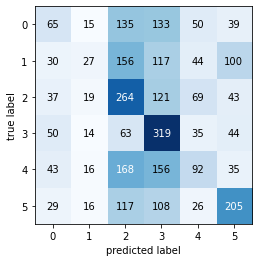

0 = Buildings, 1 = Forest,  2 = Glacier, 3 = Mountain, 4 = Sea, 5 = Street


In [35]:
mnb = MultinomialNB()
y_pred_multi = mnb.fit(X_train,y_train).predict(X_test)

accu_Multinomial = accuracy_score(y_test, y_pred_multi)
mcm_Multinomial = confusion_matrix(y_target=y_test,
                                y_predicted=y_pred_multi,
                                binary=False)
print("Accuracy for the Multinomial Naive Bayes: ", accu_Multinomial*100,"%")
# print(mcm_Gaussian)

fig, ax = plot_confusion_matrix(conf_mat=mcm_Multinomial)
plt.show()
print("0 = Buildings, 1 = Forest,  2 = Glacier, 3 = Mountain, 4 = Sea, 5 = Street")


Accuracy for the Gaussian Naive Bayes:  41.5 %


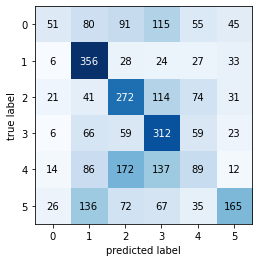

0 = Buildings, 1 = Forest,  2 = Glacier, 3 = Mountain, 4 = Sea, 5 = Street


In [36]:
gnb = GaussianNB()
y_pred_gauss = gnb.fit(X_train,y_train).predict(X_test)

accu_Gaussian = accuracy_score(y_test, y_pred_gauss)
mcm_Gaussian = confusion_matrix(y_target=y_test,
                                y_predicted=y_pred_gauss,
                                binary=False)
print("Accuracy for the Gaussian Naive Bayes: ", accu_Gaussian*100,"%")
# print(mcm_Gaussian)

fig, ax = plot_confusion_matrix(conf_mat=mcm_Gaussian)
plt.show()
print("0 = Buildings, 1 = Forest,  2 = Glacier, 3 = Mountain, 4 = Sea, 5 = Street")



Accuracy for the Complement Naive Bayes:  30.566666666666663 %


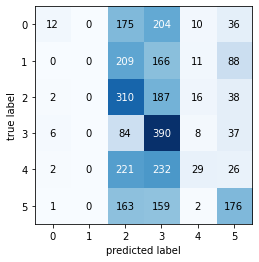

0 = Buildings, 1 = Forest,  2 = Glacier, 3 = Mountain, 4 = Sea, 5 = Street


In [37]:
cnb = ComplementNB()
y_pred_compl = cnb.fit(X_train,y_train).predict(X_test)

accu_Complement= accuracy_score(y_test, y_pred_compl)
mcm_Complement = confusion_matrix(y_target=y_test,
                                y_predicted=y_pred_compl,
                                binary=False)
print("Accuracy for the Complement Naive Bayes: ", accu_Complement*100,"%")
# print(mcm_Gaussian)

fig, ax = plot_confusion_matrix(conf_mat=mcm_Complement)
plt.show()
print("0 = Buildings, 1 = Forest,  2 = Glacier, 3 = Mountain, 4 = Sea, 5 = Street")


With Naive-Bayes neural networks, we can see that image recognition is not accurate at all, and is not a viable option.
The images that possesses the same color throughout the set are easier to predict for a Naive-Bayes neural network, such as glacier, forest and mountain.

The difficulties that I had for this part of the portfolio were:
The treatment of the images, and getting them into a dataset on a single line to have an easier time manipulating it.
Also, the confusion matrixes were a bit hard to do since I had 6 categories, so I had to install a different package that allowed me to do it quickly.

# K-Means Clustering

In [38]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [39]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)
X_reduced = X_reduced.astype('double')

In [40]:
print(X_reduced)

[[-0.38682532  1.28035593]
 [-1.06940639  2.348351  ]
 [ 4.48251629 -1.3232075 ]
 ...
 [-0.17305905 -1.28069031]
 [-0.99418962  2.31031489]
 [-2.47190309 -0.68745422]]


I chose to reduce the dimensionality of my dataset to two dimensions using PCA to be able to plot my clusters on a graph.

In [41]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred_kmeans = kmeans.fit_predict(X_reduced)

At first, I used the kmeans algorithms with the same number of clusters as classes my dataset has.

In [42]:
y_pred_kmeans

array([5, 5, 1, ..., 2, 5, 0])

In [43]:
y_pred_kmeans is kmeans.labels_

True

In [44]:
kmeans.cluster_centers_

array([[-2.75716133, -2.82473933],
       [ 5.84475205,  0.10575209],
       [ 1.73920379, -2.1523763 ],
       [-4.43985892,  1.3577454 ],
       [-0.702805  ,  5.27975296],
       [ 0.46313818,  1.1251514 ]])

In [45]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

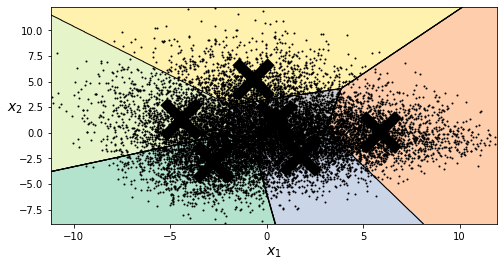

In [46]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X_reduced)
plt.show()

Since my dataset is complex and there is not so much similar featires between images of the same classes, the clustering is very messy, with no real clusters forming.

In [47]:
def retrieve_info(cluster_labels,y_train):

# Initializing
    reference_labels = {}
# For loop to run through each label of cluster label
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [48]:
reference_labels = retrieve_info(kmeans.labels_,y_train_int)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
  number_labels[i] = reference_labels[kmeans.labels_[i]]

In [49]:
print(accuracy_score(number_labels,y_train_int))

0.33404588855636314


The kmeans clustering algorithm is still somewhat effective, with an accuracy of 33%, better than a random guess (1/6 or 16%)

In [50]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

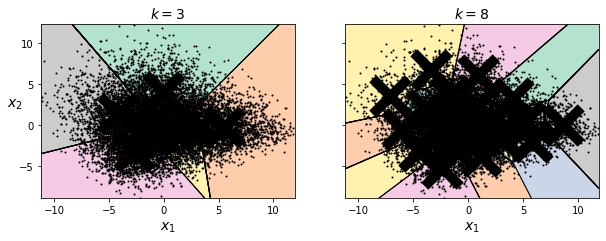

In [51]:
kmeans_k5 = KMeans(n_clusters=5, random_state=42)
kmeans_k20 = KMeans(n_clusters=20, random_state=42)

plot_clusterer_comparison(kmeans_k5, kmeans_k20, X_reduced, "$k=3$", "$k=8$")
plt.show()

Still, since my dataset does not have similar features for images of the same class, there is still no real clusters forming.

In [52]:
X_less = X_reduced[0:2000]
y_train_int_less = y_train_int[0:2000]

In [53]:
k = 6
kmeans_less = KMeans(n_clusters=k, random_state=42)
y_pred_kmeans_less = kmeans.fit_predict(X_less)

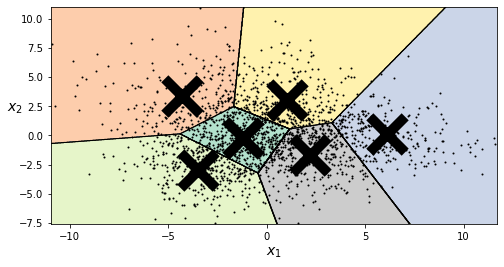

In [54]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X_less)
plt.show()

In [55]:
reference_labels = retrieve_info(kmeans.labels_,y_train_int_less)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
  number_labels[i] = reference_labels[kmeans.labels_[i]]
print(accuracy_score(number_labels,y_train_int_less))

0.3205


In [56]:
kmeans.inertia_

9644.799173538138

In [57]:
kmeans_k5.inertia_

77648.68826203285

In [58]:
kmeans_k20.inertia_

22353.925339084926

In [59]:
# k = 6
# kmeans_full = KMeans(n_clusters=k, random_state=42)
# y_pred_kmeans = kmeans_full.fit_predict(X_train)

In [60]:
# reference_labels = retrieve_info(kmeans_full.labels_,y_train_int)
# number_labels = np.random.rand(len(kmeans_full.labels_))
# for i in range(len(kmeans_full.labels_)):
#   number_labels[i] = reference_labels[kmeans_full.labels_[i]]

Since the images are very complex, and I reduced the dimension of each image to 2 to be able to plot them, we don't get a very good accuracy

# Decision Tree, Linear Regression and Logistic Regression

In [61]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier,plot_tree

In [62]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

[Text(167.4, 181.2, 'X[210] <= 0.473\ngini = 0.833\nsamples = 14034\nvalue = [2191, 2271, 2404, 2512, 2274, 2382]'),
 Text(83.7, 108.72, 'X[75] <= 0.786\ngini = 0.806\nsamples = 6537\nvalue = [920, 1791, 903, 590, 759, 1574]'),
 Text(41.85, 36.23999999999998, 'gini = 0.799\nsamples = 5149\nvalue = [713, 1678, 745, 444, 665, 904]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.71\nsamples = 1388\nvalue = [207, 113, 158, 146, 94, 670]'),
 Text(251.10000000000002, 108.72, 'X[610] <= 0.453\ngini = 0.809\nsamples = 7497\nvalue = [1271, 480, 1501, 1922, 1515, 808]'),
 Text(209.25, 36.23999999999998, 'gini = 0.795\nsamples = 4625\nvalue = [837, 373, 588, 1521, 797, 509]'),
 Text(292.95, 36.23999999999998, 'gini = 0.782\nsamples = 2872\nvalue = [434, 107, 913, 401, 718, 299]')]

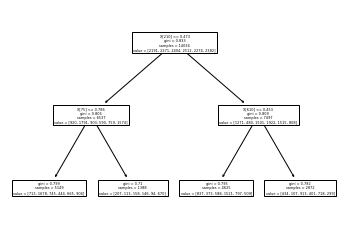

In [63]:
plot_tree(tree_clf)

At first, I did a basic Decision Tree with only a depth of 2 to see if it was able to distinguish between 6 classes.

In [64]:
tree_clf.predict_proba(X_test)

array([[0.15111421, 0.03725627, 0.31789694, 0.13962396, 0.25      ,
        0.10410864],
       [0.13847349, 0.32588852, 0.14468829, 0.08623034, 0.12915129,
        0.17556807],
       [0.13847349, 0.32588852, 0.14468829, 0.08623034, 0.12915129,
        0.17556807],
       ...,
       [0.18097297, 0.08064865, 0.12713514, 0.32886486, 0.17232432,
        0.11005405],
       [0.13847349, 0.32588852, 0.14468829, 0.08623034, 0.12915129,
        0.17556807],
       [0.18097297, 0.08064865, 0.12713514, 0.32886486, 0.17232432,
        0.11005405]])

In [65]:
tree_clf.predict_proba(X_train)
y_pred_clf_train = tree_clf.predict(X_train)

print(accuracy_score(y_pred_clf_train,y_train))

0.34074390765284307


As we can see, it is still a better accuracy than a random guess, but it is still not good enough.

In [66]:
y_pred_clf = tree_clf.predict(X_test)
y_pred_clf

array(['glacier', 'forest', 'forest', ..., 'mountain', 'forest',
       'mountain'], dtype=object)

In [67]:
print(accuracy_score(y_pred_clf,y_test))

0.328


In [68]:
tree_clf_deep = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deep.fit(X_reduced, y_train)


DecisionTreeClassifier(max_depth=3, random_state=42)

[Text(167.4, 190.26, 'X[0] <= 1.582\ngini = 0.833\nsamples = 14034\nvalue = [2191, 2271, 2404, 2512, 2274, 2382]'),
 Text(83.7, 135.9, 'X[1] <= -1.304\ngini = 0.814\nsamples = 9712\nvalue = [1663, 506, 2127, 2143, 1850, 1423]'),
 Text(41.85, 81.53999999999999, 'X[1] <= -4.032\ngini = 0.758\nsamples = 3373\nvalue = [573, 109, 385, 1335, 559, 412]'),
 Text(20.925, 27.180000000000007, 'gini = 0.529\nsamples = 763\nvalue = [77, 16, 47, 508, 81, 34]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.791\nsamples = 2610\nvalue = [496, 93, 338, 827, 478, 378]'),
 Text(125.55000000000001, 81.53999999999999, 'X[1] <= 4.495\ngini = 0.808\nsamples = 6339\nvalue = [1090, 397, 1742, 808, 1291, 1011]'),
 Text(104.625, 27.180000000000007, 'gini = 0.815\nsamples = 5603\nvalue = [1038, 382, 1341, 741, 1159, 942]'),
 Text(146.475, 27.180000000000007, 'gini = 0.649\nsamples = 736\nvalue = [52, 15, 401, 67, 132, 69]'),
 Text(251.10000000000002, 135.9, 'X[0] <= 3.335\ngini = 0.748\nsamples = 4322\n

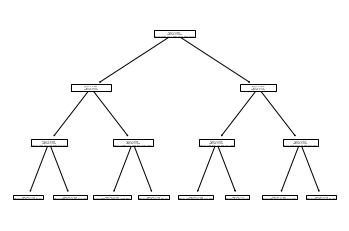

In [69]:
plot_tree(tree_clf_deep)

Next, I basically just increased the depth of the tree, but it did not change the accuracy very much.

In [70]:
y_pred_clf_deep = tree_clf.predict(X_train)
y_pred_clf_deep
print(accuracy_score(y_pred_clf_deep,y_train))

0.34074390765284307


In [71]:
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf3 = DecisionTreeClassifier(max_leaf_nodes=5, random_state=42)
deep_tree_clf4 = DecisionTreeClassifier(max_depth=10,min_samples_leaf=10, random_state=42)
deep_tree_clf5 = DecisionTreeClassifier(max_depth=40,min_samples_leaf=40, random_state=42)


deep_tree_clf1.fit(X_train, y_train)
deep_tree_clf2.fit(X_train, y_train)
deep_tree_clf3.fit(X_train, y_train)
deep_tree_clf4.fit(X_train, y_train)
deep_tree_clf5.fit(X_train, y_train)

y_score_1 = deep_tree_clf1.score(X_test,y_test)
y_score_2 = deep_tree_clf2.score(X_test,y_test)
y_score_3 = deep_tree_clf3.score(X_test,y_test)
y_score_4 = deep_tree_clf4.score(X_test,y_test)
y_score_5 = deep_tree_clf5.score(X_test,y_test)

print('Accuracy with tree freedoms              : ', round(y_score_1*100,2),'%')
print('Accuracy min 4 sample leaf               : ', round(y_score_2*100,2),'%')
print('Accuracy max 5 leaf node                 : ', round(y_score_3*100,2),'%')
print('Accuracy min 10 sample leaf, max depth 10: ', round(y_score_4*100,2),'%')
print('Accuracy min 20 sample leaf, max depth 20 (trying to overfit): ', round(y_score_5*100,2),'%')

Accuracy with tree freedoms              :  35.6 %
Accuracy min 4 sample leaf               :  37.0 %
Accuracy max 5 leaf node                 :  34.43 %
Accuracy min 10 sample leaf, max depth 10:  40.63 %
Accuracy min 20 sample leaf, max depth 20 (trying to overfit):  41.1 %


Since I chose a pretty complex dataset, with no really easy common properties between images of the same class, the decision has to be pretty complex (deep) to get better results.

# Neural Network

In [72]:
import sklearn
import tensorflow as tf
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [73]:
from sklearn.linear_model import Perceptron

In [74]:
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X_train, y_train)

Perceptron(random_state=42)

In [75]:
y_pred_percep = per_clf.predict(X_test)
y_pred_percep
print(accuracy_score(y_pred_percep,y_test))

0.339


Quick experimentation with perceptron, then creation of an ANN with KERAS tensorflow

In [76]:
from tensorflow import keras

In [77]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(500, activation="relu")) #hidden layer with 300 neurons useing the ReLU activation function.
model.add(keras.layers.Dense(100, activation="relu")) #hidden layer with 100 neurons using the ReLU

model.add(keras.layers.Dense(6, activation="softmax")) #output layer with 10 neurons (one per class), using the softmax 

In [78]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [79]:
model.layers

In [80]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(), #"sgd" simply means that we will train the model using simple Stochastic Gradient Descent
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [81]:
history = model.fit(X_train, y_train_int, epochs=30,
                    validation_data=(X_test, y_test_int))

Epoch 1/30
439/439 [==============================] - 2s 4ms/step - loss: 1.6209 - sparse_categorical_accuracy: 0.3340 - val_loss: 1.9540 - val_sparse_categorical_accuracy: 0.0653
Epoch 2/30
439/439 [==============================] - 1s 3ms/step - loss: 1.5322 - sparse_categorical_accuracy: 0.3895 - val_loss: 1.8871 - val_sparse_categorical_accuracy: 0.1113
Epoch 3/30
439/439 [==============================] - 1s 3ms/step - loss: 1.4791 - sparse_categorical_accuracy: 0.4215 - val_loss: 1.9655 - val_sparse_categorical_accuracy: 0.1230
Epoch 4/30
439/439 [==============================] - 1s 3ms/step - loss: 1.4363 - sparse_categorical_accuracy: 0.4447 - val_loss: 2.1232 - val_sparse_categorical_accuracy: 0.0893
Epoch 5/30
439/439 [==============================] - 1s 3ms/step - loss: 1.3998 - sparse_categorical_accuracy: 0.4615 - val_loss: 2.0727 - val_sparse_categorical_accuracy: 0.1100
Epoch 6/30
439/439 [==============================] - 1s 3ms/step - loss: 1.3651 - sparse_categorica

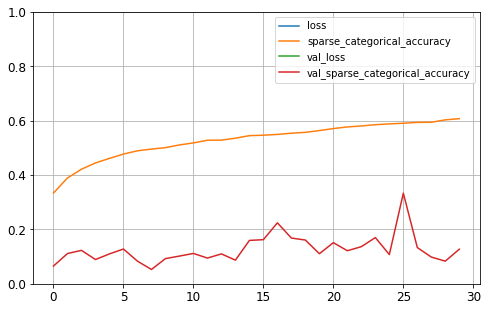

In [82]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

A basic ANN gives us a better accuracy than the others machine learning algorithms but is still not perfect

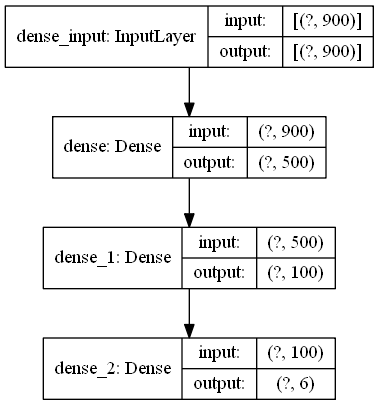

In [83]:
keras.utils.plot_model(model, "Intel_Image_Model.png", show_shapes=True)

In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               450500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 501,206
Trainable params: 501,206
Non-trainable params: 0
_________________________________________________________________


# 

# Convolutionnal Neural Network

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras


from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [86]:
labels = ['buildings', 'forest','glacier','mountain','sea','street']
img_size = 30
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [87]:
def get_data_pred(data_dir):
    data = [] 
    path = os.path.join(data_dir)
    for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            data.append([resized_arr])
        except Exception as e:
            print(e)
    return np.array(data)

In [88]:
train = get_data('Intel Image Classification/seg_train')
val = get_data('Intel Image Classification/seg_test')

C:\Users\aroze\AppData\Local\Temp/ipykernel_4428/4121517644.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [89]:
pred = get_data_pred('Intel Image Classification/seg_pred')

In [90]:
mainFolderTrain = 'Intel Image Classification/seg_train'
mainFolderTest = 'Intel Image Classification/seg_test'
mainFolderPred = 'Intel Image Classification/seg_pred'

In [91]:
x_train = []
y_train = []
x_val = []
y_val = []
x_pred = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature in pred:
  x_pred.append(feature)
    
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_pred = np.array(x_pred) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_pred.reshape(-1, img_size, img_size, 1)

array([[[[0.83921569],
         [0.74901961],
         [0.62745098],
         ...,
         [0.66666667],
         [0.79215686],
         [0.97647059]],

        [[0.54117647],
         [0.70980392],
         [0.91764706],
         ...,
         [0.42352941],
         [0.62352941],
         [0.88235294]],

        [[0.52941176],
         [0.68627451],
         [0.9254902 ],
         ...,
         [0.9372549 ],
         [0.65098039],
         [0.25098039]],

        ...,

        [[0.36078431],
         [0.21568627],
         [0.15294118],
         ...,
         [0.36862745],
         [0.61960784],
         [0.42352941]],

        [[0.60784314],
         [0.78431373],
         [0.94901961],
         ...,
         [0.82745098],
         [0.90588235],
         [0.94117647]],

        [[0.67058824],
         [0.8       ],
         [0.92156863],
         ...,
         [0.74117647],
         [0.54901961],
         [0.27843137]]],


       [[[0.63921569],
         [0.45882353],
         [0.25

I had to fetch my data from the files again since I flattened them earlier, and for the CNN, it was easier if each image was still in its 2D format. Also, I did not greyscale them to give more information to the CNN.

In [92]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(30,30,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(6, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 64)          0

In [93]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [94]:
history = model.fit(x_train,y_train,epochs = 120 , validation_data = (x_val, y_val))

Epoch 1/120
439/439 [==============================] - 9s 21ms/step - loss: 1.6382 - accuracy: 0.4072 - val_loss: 1.5381 - val_accuracy: 0.4963
Epoch 2/120
439/439 [==============================] - 9s 21ms/step - loss: 1.5275 - accuracy: 0.5118 - val_loss: 1.4847 - val_accuracy: 0.5610
Epoch 3/120
439/439 [==============================] - 9s 20ms/step - loss: 1.4766 - accuracy: 0.5658 - val_loss: 1.4568 - val_accuracy: 0.5890
Epoch 4/120
439/439 [==============================] - 10s 22ms/step - loss: 1.4550 - accuracy: 0.5886 - val_loss: 1.4466 - val_accuracy: 0.5997
Epoch 5/120
439/439 [==============================] - 9s 21ms/step - loss: 1.4389 - accuracy: 0.6037 - val_loss: 1.4317 - val_accuracy: 0.6140
Epoch 6/120
439/439 [==============================] - 9s 21ms/step - loss: 1.4224 - accuracy: 0.6204 - val_loss: 1.4023 - val_accuracy: 0.6433
Epoch 7/120
439/439 [==============================] - 9s 21ms/step - loss: 1.4053 - accuracy: 0.6417 - val_loss: 1.3974 - val_accuracy

439/439 [==============================] - 15s 34ms/step - loss: 1.2593 - accuracy: 0.7864 - val_loss: 1.2792 - val_accuracy: 0.7620
Epoch 58/120
439/439 [==============================] - 9s 21ms/step - loss: 1.2579 - accuracy: 0.7894 - val_loss: 1.2663 - val_accuracy: 0.7783
Epoch 59/120
439/439 [==============================] - 10s 23ms/step - loss: 1.2564 - accuracy: 0.7881 - val_loss: 1.2638 - val_accuracy: 0.7800
Epoch 60/120
439/439 [==============================] - 10s 23ms/step - loss: 1.2518 - accuracy: 0.7944 - val_loss: 1.2657 - val_accuracy: 0.7810
Epoch 61/120
439/439 [==============================] - 11s 24ms/step - loss: 1.2565 - accuracy: 0.7881 - val_loss: 1.2596 - val_accuracy: 0.7847
Epoch 62/120
439/439 [==============================] - 9s 21ms/step - loss: 1.2540 - accuracy: 0.7899 - val_loss: 1.2633 - val_accuracy: 0.7810
Epoch 63/120
439/439 [==============================] - 10s 23ms/step - loss: 1.2532 - accuracy: 0.7926 - val_loss: 1.2596 - val_accuracy: 

439/439 [==============================] - 10s 23ms/step - loss: 1.2172 - accuracy: 0.8290 - val_loss: 1.2403 - val_accuracy: 0.8043
Epoch 114/120
439/439 [==============================] - 10s 22ms/step - loss: 1.2166 - accuracy: 0.8303 - val_loss: 1.2430 - val_accuracy: 0.7997
Epoch 115/120
439/439 [==============================] - 10s 22ms/step - loss: 1.2184 - accuracy: 0.8276 - val_loss: 1.2366 - val_accuracy: 0.8090
Epoch 116/120
439/439 [==============================] - 9s 21ms/step - loss: 1.2132 - accuracy: 0.8329 - val_loss: 1.2411 - val_accuracy: 0.8020
Epoch 117/120
439/439 [==============================] - 10s 23ms/step - loss: 1.2150 - accuracy: 0.8301 - val_loss: 1.2375 - val_accuracy: 0.8100
Epoch 118/120
439/439 [==============================] - 11s 24ms/step - loss: 1.2149 - accuracy: 0.8313 - val_loss: 1.2402 - val_accuracy: 0.8033
Epoch 119/120
439/439 [==============================] - 10s 24ms/step - loss: 1.2105 - accuracy: 0.8360 - val_loss: 1.2351 - val_acc

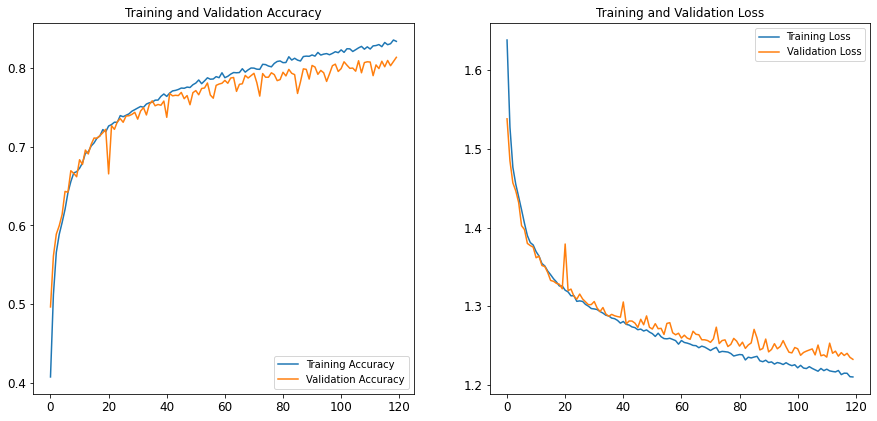

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(120)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It was logical, but a CNN gives way better results with an accuracy of 80%.

In [96]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Buildings (Class 0)','Forest (Class 1)','Glacier (Class 2)','Mountain (Class 3)','Sea (Class 4)','Street (Class 5)']))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
                     precision    recall  f1-score   support

Buildings (Class 0)       0.79      0.76      0.77       437
   Forest (Class 1)       0.91      0.93      0.92       474
  Glacier (Class 2)       0.78      0.80      0.79       553
 Mountain (Class 3)       0.82      0.76      0.79       525
      Sea (Class 4)       0.77      0.81      0.79       510
   Street (Class 5)       0.82      0.83      0.83       501

           accuracy                           0.81      3000
          macro avg       0.82      0.81      0.81      3000
       weighted avg       0.81      0.81      0.81      3000



Here, we can see the details for each class with the accuracy, recall, f-score and support.

In [97]:
test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=0)
print('\nTest accuracy:', test_acc)


Test accuracy: 0.8140000104904175


In [98]:
classifications = model.predict(x_val)

In [99]:
print(classifications[3])

[9.9999905e-01 2.3574192e-12 7.6805620e-09 2.8404880e-13 9.5639302e-07
 5.9846912e-11]


In [100]:
class_names = ['Buildings (Class 0)','Forest (Class 1)','Glacier (Class 2)','Mountain (Class 3)','Sea (Class 4)','Street (Class 5)']

Buildings (Class 0)


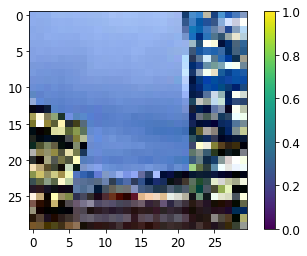

In [101]:
print(class_names[np.argmax(classifications[3])])
plt.imshow(x_val[3].reshape(30,30,3))
plt.colorbar()
plt.grid(False)

Buildings (Class 0)


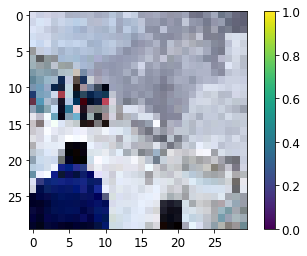

In [102]:
print(class_names[np.argmax(classifications[1000])])
plt.imshow(x_val[1000].reshape(30,30,3))
plt.colorbar()
plt.grid(False)

# Research Question

## How to get better results from my dataset and get better running times (especially for CNN) ?

Since my dataset is complex, I did not get good results from the different methods used above. The only method that gave pretty good results was the convolutionnal neural network.
In my opinion, I could have had better results for Supervised and Unsupervised Learning if I used better feature selection methods.

The first mistake I made in my opinion was converting the images in greyscale. Since for the 6 categories (Buildings, Forest, Sea, Glacier, Street, Mountain) the principal color of the image is very important in differenciating a Mountain and a Glacier.

In the CNN part, since I had to get my data from the files again, I did not convert them in grayscale, and I got good results, but that could be the effect of the CNN being more adapted to image recognition than the other methods.

The easiest way to get better running times as well as a pretty basic feature selection methods is to downscale the images enough to get fewer pixels but not too much as to not lose too much information.

For feature selection, depending on if we are doing supervised or unsupervised learning, there exist different types of methods.
For supervised learning, since my input is numerical, we have three viable options:
    
    A wrapper type method. This method is searching for subsets of features that are well performing. One of the methods is the RFE (Recursive Feature Elimination). This method works by using a machine learning alogorithm wrapped inside the RFE methods, and is eliminating the features that perform worse to try and get only the most important ones. For example, the RFE method can be implemented with a Decision Tree Classifier to get the best features, and then, another type of ML algorithm can be used with the selected features.
    
    A filter type method. Two method exists that are pretty good for numerical input. One is Feature Importance, where each feature is assigned a score that show the importance of the feature for the prediction. We can use Linear Regression to get the coefficient for each feature, or Logistic Regression.
    
    An intrinsinc type method. This is a method like a Decision Tree, where there is a automatic feature selection during the training.
    
For unsupervised learning, it's a little bit more complicated, because we don't have a way to get the best features based on their category, since it is not known. The only type of feature selection that I found was dimensionality reduction, with PCA, Linear Discriminant Analysis, Non-negative Matrix Factorisation.

In [103]:
from sklearn.feature_selection import RFE
# define the method
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=100)
# fit the model
rfe.fit(x_train, y_train)
# transform the data
x_rfe, y_rfe = rfe.transform(x_train, y_train)

ValueError: Found array with dim 4. Estimator expected <= 2.